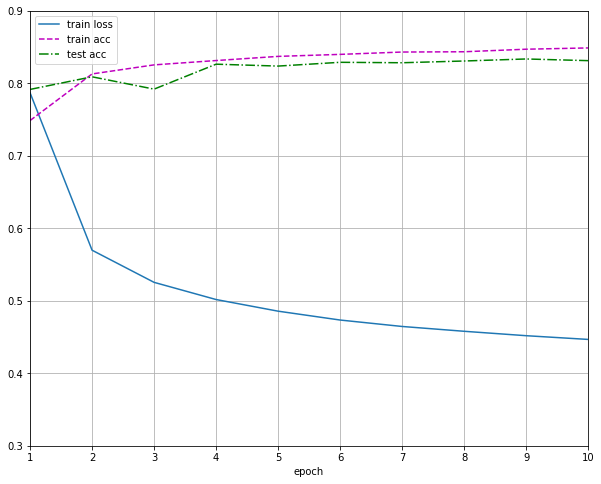

In [1]:
import torch
from utils import Accumulator
from utils.plot import Animator
from utils.downloader import load_data_fashion_mnist


def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition


def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


def cross_entropy(y_hat, y):
    """交叉熵损失函数"""
    return -torch.log(y_hat[range(len(y_hat)), y])


def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)

    # y_hat.type(y.dtype): 将 y_hat 转换成 y 的数据类型
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()

    metric = Accumulator(2)

    # y.numel(): 获取元素个数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())

    return metric[0] / metric[1]


def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)

        if isinstance(updater, torch.optim.Optimizer):
            # 使用 PyTorch 内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=["train loss", "train acc", "test acc"])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics


def sgd(params, lr, batch_size):
    """小批量随机梯度下降 SGD"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


def updater(batch_size):
    return sgd([W, b], lr, batch_size)


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

print(evaluate_accuracy(net, test_iter))

# 切片示例
print("=" * 20, "Tensor切片示例", "=" * 20)
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.2, 0.3, 0.5]])
print(y_hat[[0, 1], y])
print(y_hat.numel())

lr = 0.1
num_epochs = 10
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

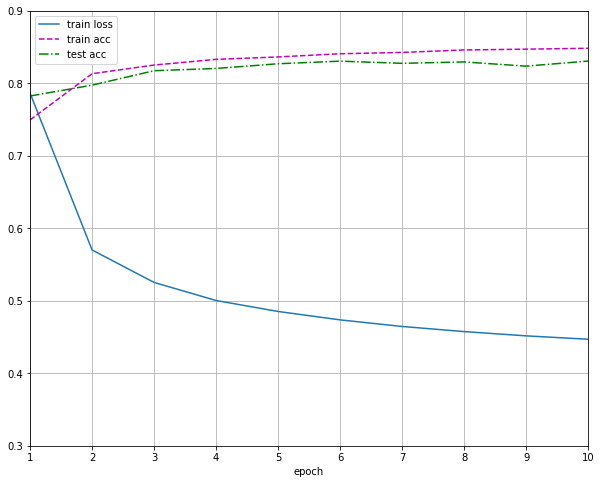

In [2]:
import torch
from torch import nn
from utils import Accumulator
from utils.plot import Animator
from utils.downloader import load_data_fashion_mnist


def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)

    # y_hat.type(y.dtype): 将 y_hat 转换成 y 的数据类型
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()

    metric = Accumulator(2)

    # y.numel(): 获取元素个数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())

    return metric[0] / metric[1]


def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)

        if isinstance(updater, torch.optim.Optimizer):
            # 使用 PyTorch 内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=["train loss", "train acc", "test acc"])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    # train_loss, train_acc = train_metrics


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
# PyTorch 不会隐式调整输入的形状
# 因此，定义展平层(flatten) 在线性层前调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
net.apply(init_weights)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
train(net, train_iter, test_iter, loss, num_epochs, trainer)
